# Titanic Dataset Analysis with XGBoost

In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Importing necessaary Packages

In [148]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

# Loading Datasets[](http://)

In [149]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")

whole_data = train_data.append(test_data)
whole_data.reset_index(inplace=True)
whole_data.drop('index',inplace=True,axis=1)
print("Dimension of whole dataset: {}".format(whole_data.shape)+"\n")
print("Dimension of train dataset: {}".format(train_data.shape)+"\n")
print("Dimension of test dataset: {}".format(test_data.shape)+"\n")



Dimension of whole dataset: (1309, 12)

Dimension of train dataset: (891, 12)

Dimension of test dataset: (418, 11)



We don't need PassengerID, So droping this column

In [150]:
train_data = train_data.drop('PassengerId', axis = 1)


# **Exploring Data**

In [151]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [115]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


There are some missing values.

In [116]:
train_data.apply(lambda x: sum(x.isnull()))

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [152]:
test_data.apply(lambda x: sum(x.isnull()))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Summary of the neumerical data. 'Age', 'SibSp', 'Parch', 'Fare' have neumerical data.

In [153]:
whole_data.loc[:,['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.498854,0.385027,33.295479
std,14.413493,1.041658,0.865560,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


'Survived','Pclass', 'Sex', 'Embarked' have categorical data.

In [154]:
cat_var=['Survived','Pclass', 'Sex', 'Embarked']

for i in cat_var:
     print (train_data[i].value_counts()) 


0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


# Visualizing

Text(0.5, 1.0, 'Survival Count')

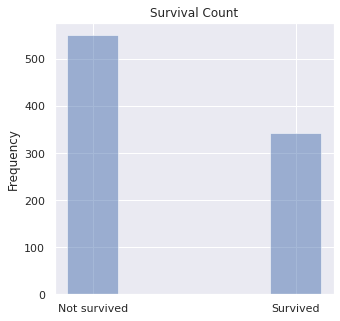

In [155]:
plt.figure(figsize=(5,5))
labels = ('Not survived', 'Survived')
x_pos = np.arange(len(labels))
plt.bar(x_pos, train_data['Survived'].value_counts(), align='center', alpha=0.5, width=0.25)
plt.xticks(x_pos, labels)
plt.ylabel('Frequency')
plt.title('Survival Count')

Exploring the distribution of Pclass by survival variable.

Text(0.5, 1.0, 'Survived vs Pclass')

<Figure size 360x360 with 0 Axes>

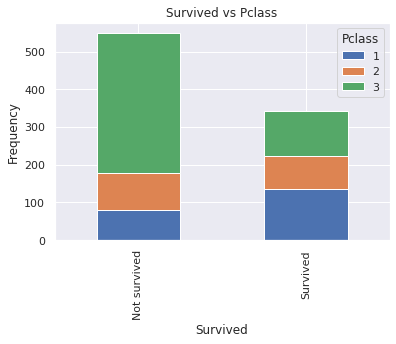

In [156]:
plt.figure(figsize=(5,5))
labels = ('Not survived', 'Survived')
x_pos = np.arange(len(labels))
df_temp = pd.crosstab(train_data["Survived"], train_data['Pclass']).plot(kind = 'bar', stacked='True')
plt.xticks(x_pos, labels)
plt.ylabel('Frequency')
plt.title('Survival Count')
plt.title('Survived'+" vs "+'Pclass')


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


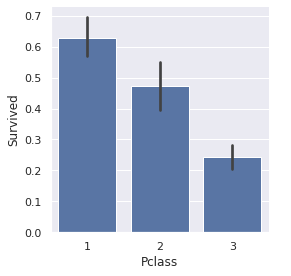

In [158]:
ax = sns.FacetGrid(train_data,  margin_titles=True, size = 4)
ax = ax.map(sns.barplot, 'Pclass', 'Survived') 
ax.add_legend()

The passnegers holding higher-class tickets have the highest chance of survival. They are, then, followed by the middle-class tickets. 

 The same analysis is done for gender and embarkation port as shown below.

Text(0.5, 1.0, 'Survived vs Sex')

<Figure size 360x360 with 0 Axes>

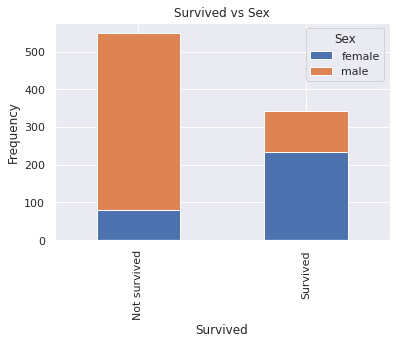

In [159]:
plt.figure(figsize=(5,5))
labels = ('Not survived', 'Survived')
x_pos = np.arange(len(labels))
df_temp = pd.crosstab(train_data["Survived"], train_data['Sex']).plot(kind = 'bar', stacked='True')
plt.xticks(x_pos, labels)
plt.ylabel('Frequency')
plt.title('Survival Count')
plt.title('Survived'+" vs "+'Sex')

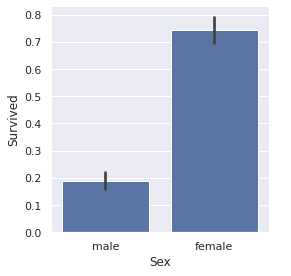

In [160]:
ax = sns.FacetGrid(train_data,  margin_titles=True, size = 4)
ax = ax.map(sns.barplot, 'Sex', 'Survived') 
ax.add_legend()

Most people survived are females.

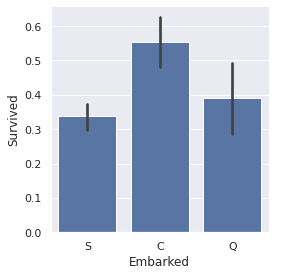

In [161]:
ax = sns.FacetGrid(train_data,  margin_titles=True, size = 4)
ax = ax.map(sns.barplot, 'Embarked', 'Survived') 
ax.add_legend()

As we have seen females have higher chance than males. Now we will see the distribution of ages.

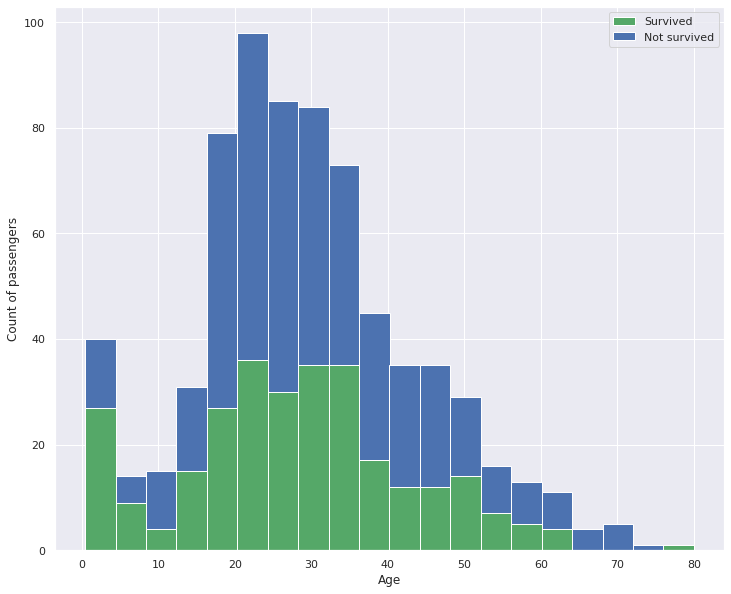

In [162]:
plt.figure(figsize=(12,10))
plt.hist([train_data[train_data['Survived']==1]['Age'].dropna(), train_data[train_data['Survived']==0]['Age'].dropna()], stacked=True, color = ['g','b'],
bins = 20,label = ['Survived','Not survived'])
plt.xlabel('Age')
plt.ylabel('Count of passengers')
plt.legend()

Passengers' age distribution per gender in the full dataset.

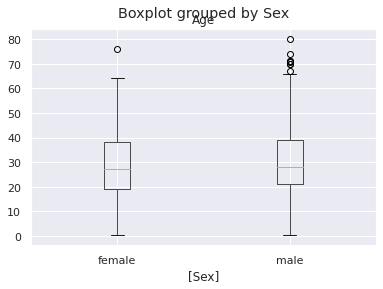

In [164]:
whole_data.boxplot(column ='Age', by = ['Sex'])

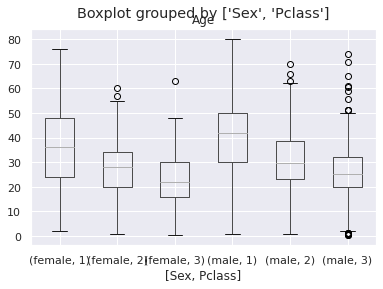

In [165]:
whole_data.boxplot(column ='Age', by = ['Sex','Pclass'])

The female passengers in the lower class of tickets are considered as the youngest group of Titanic passenfers

Plotting the correlation matrix which investigates the dependence between multiple variables. As shown by the correlation plot, SibSp and Parch are quite correlated.

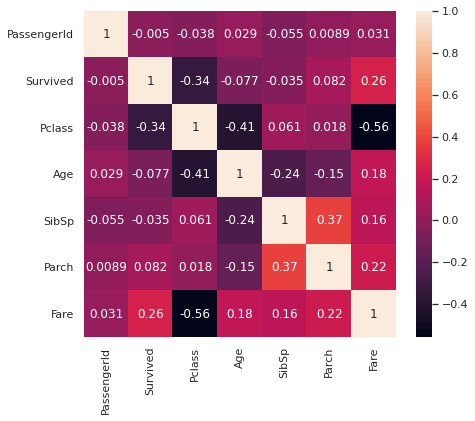

In [166]:
corr = whole_data.corr()
ax = plt.subplots(figsize =(7, 6))
sns.heatmap(corr,annot = True)

Imputing missing values

The number of missing values per each variable in Titanic dataset, except the target one, is given below.

In [167]:
whole_data.drop(['PassengerId', 'Survived'], axis =1).apply(lambda x: sum(x.isnull()))

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [168]:
whole_data['Fare'].fillna(whole_data.Fare.median(), inplace = True)
whole_data['Embarked'].fillna(whole_data.Embarked.mode()[0], inplace = True)
whole_data['Cabin'].fillna("N", inplace = True) 
whole_data['Cabin']=whole_data['Cabin'].dropna().map(lambda x: x[0])

In [169]:
pd.crosstab(whole_data['Pclass'], whole_data['Cabin'])

Cabin,A,B,C,D,E,F,G,N,T
Pclass,,,,,,,,,
1,22,65,94,40,34,0,0,67,1
2,0,0,0,6,4,13,0,254,0
3,0,0,0,0,3,8,5,693,0


The missing value for this feature can be estimated wisely given the mode value for all categories of cabin number per each Pclass.

In [170]:
for i, row in whole_data.iterrows():
    whole_data.loc[(whole_data['Pclass']==1) & (whole_data['Cabin']=="N"), 'Cabin'] = 'C'
    whole_data.loc[(whole_data['Pclass']==2) & (whole_data['Cabin']=="N"), 'Cabin'] = 'F'
    whole_data.loc[(whole_data['Pclass']==3) & (whole_data['Cabin']=="N"), 'Cabin'] = 'F'

In [171]:
whole_data['Age'] = whole_data.groupby(['Sex','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [172]:
whole_data= whole_data.drop(['Name', 'Parch', 'SibSp', 'Ticket'], axis=1)

Transforming categorical values

In [173]:
var_mod=whole_data.dtypes[whole_data.dtypes == "object"].index.tolist()
var_mod.append('Pclass')
le = LabelEncoder()
for i in var_mod:
    whole_data[i] = le.fit_transform(whole_data[i])

# Applying XGBoost

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.129612         0.006962         0.210271        0.019912
1          0.127203         0.008870         0.200684        0.018775
2          0.121989         0.009325         0.195794        0.011428
3          0.120383         0.006294         0.200619        0.012011
4          0.114362         0.008641         0.192619        0.000758
5          0.109947         0.009125         0.190981        0.008693
6          0.107138         0.008877         0.189381        0.007547
7          0.105533         0.009662         0.189368        0.012463
Accuracy score (test): 0.8208955223880597


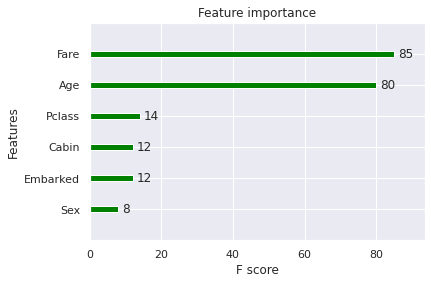

In [174]:
predictor = whole_data.drop(['PassengerId', 'Survived'], axis = 1).columns.tolist()
dataset = whole_data[:891].drop('PassengerId', axis=1)
outcome = 'Survived'

X_train, X_test, y_train, y_test = train_test_split(dataset[predictor], dataset[outcome], test_size = 0.30, random_state = 0)
    
def _modelfit(xgb_model, dataset, outcome, **kwargs):  
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    cvresult = xgb.cv(xgb_model.get_xgb_params(), dtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=5, metrics='error', early_stopping_rounds=50, seed = 0)  
    n_boosting=cvresult.index[cvresult['test-error-mean'] == cvresult['test-error-mean'].min()].tolist()[0]+1
    print(cvresult)
    xgb_model.set_params(n_estimators=n_boosting)
    xgb_model.fit(X_train, y_train, eval_metric='error') #auc
    dtrain_predictions = xgb_model.predict(X_test)
    dtrain_predprob = xgb_model.predict_proba(X_test)[:,1]
    print ("Accuracy score (test): {}".format(accuracy_score(y_test, dtrain_predictions)))
    
    
    plot_importance(xgb_model, color = 'green')
    plt.show()
    
clf = XGBClassifier(max_depth=6, n_estimators=2000, objective='binary:logistic', 
                     subsample=1.0, colsample_bytree=1.0, random_state = 0)

_modelfit(clf, dataset, outcome, predictor = predictor)

In [175]:
def _grid_depth_weight(dataset, predictor, outcome):
       
    param_test = {
     'max_depth':[i for i in range(3,11,1)],
     'min_child_weight':[i for i in range(1,11,1)]    
    }
    
    clf = XGBClassifier(n_estimators = 23, objective='binary:logistic', subsample=1.0, colsample_bytree=1.0, random_state=0)
     
    _grid = GridSearchCV(clf, param_grid=param_test, scoring='accuracy', 
                         n_jobs=4, cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_depth_weight(dataset, predictor, outcome)

({'max_depth': 8, 'min_child_weight': 3}, 0.8298709677419355)

In [176]:
def _grid_gamma(dataset, predictor, outcome):
    
    param_test = {
      'gamma':[i/10.0 for i in range(0,20)]   
    }
    
    clf = XGBClassifier(n_estimators =23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                        subsample=1.0, colsample_bytree=1.0, random_state=0)
    
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train, y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_gamma(dataset, predictor, outcome)

({'gamma': 0.3}, 0.8266580645161291)

In [177]:
def _grid_sample(dataset, predictor, outcome):
    
    param_test = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]  
    }
    
    clf = XGBClassifier(n_estimators=23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                                                     gamma = 0.0, seed =0)
    
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_sample(dataset, predictor, outcome)

({'colsample_bytree': 0.9, 'subsample': 1.0}, 0.825083870967742)

In [178]:
def _grid_reg(dataset, predictor, outcome):
    
    param_test = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 1, 100]  
    }
    
    clf = XGBClassifier(n_estimators=23, objective='binary:logistic', max_depth=6, min_child_weight=5, 
                                                     gamma = 0.0, subsample = 0.9, colsample_bytree = 0.7, seed = 0)   
                         
    _grid = GridSearchCV(clf, param_grid = param_test, scoring='accuracy',n_jobs=4, 
                         cv=StratifiedKFold(n_splits=5)).fit(X_train,y_train)
    
    clf=_grid.best_estimator_.fit(X_train,y_train)
    
    return _grid.best_params_, _grid.best_score_

_grid_reg(dataset, predictor, outcome)

({'reg_alpha': 0.005}, 0.8298709677419355)

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.171749         0.002925         0.215058        0.022050
1           0.166536         0.010417         0.195703        0.036172
2           0.154495         0.011893         0.195716        0.029594
3           0.157299         0.008937         0.194142        0.024449
4           0.157300         0.008099         0.192529        0.025731
..               ...              ...              ...             ...
66          0.121984         0.008640         0.186142        0.016542
67          0.121181         0.009027         0.187742        0.018810
68          0.119176         0.008582         0.184529        0.017668
69          0.120379         0.007929         0.190981        0.011259
70          0.119979         0.007250         0.182929        0.018003

[71 rows x 4 columns]
Accuracy score (test): 0.832089552238806


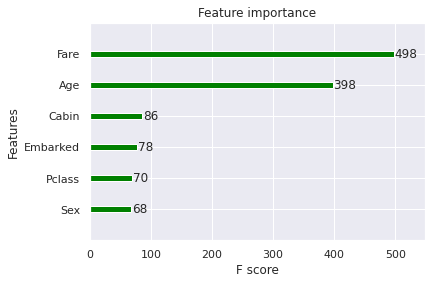

In [179]:
clf = XGBClassifier(
 learning_rate =0.05,
 n_estimators=2000,
 max_depth=8,
 min_child_weight=3,
 gamma=0.3,
 subsample=1,
 colsample_bytree=0.9,
 reg_alpha = 0.005,
 objective='binary:logistic',
 random_state=0)

_modelfit(clf, dataset, outcome)

# Exporting Output file

In [180]:
Survived = clf.predict(whole_data[891:].drop(['Survived', 'PassengerId'], axis=1)).astype(int)
PassengerId = whole_data[891:].PassengerId
xgb = pd.DataFrame({'PassengerId': _PassengerId ,'Survived': _Survived})
print("Dimension of final set: {}".format(_xgb.shape)+"\n")
print(xgb.head())
xgb.to_csv('final_2.csv', index = False)

Dimension of final set: (418, 2)

     PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         0
